# Tutorial 1: 10x Visium human DLPFC dataset (recovery)
We performed recovery experiment on 151673 sample of the human dorsolateral prefrontal cortex (DLPFC) dataset. The white matter (WM) and six cortex layers have been manually annotated. We randomly down-sampled 50% of measured spots and recovered data on all of measured spots.

Here, we demonstrate how to recover down-sampled data on 10x Visium human DLPFC dataset by STAGE. The original data with the standard format of 10x Visium data can be downloaded from [Github](https://github.com/LieberInstitute/spatialLIBD). The manual annotation are available at the spatialLIBD package and we also provided them at [Google Drive](https://drive.google.com/drive/folders/1Gp-nr9c0YGJs1l4UPRAtlIDekmXAW9hS).

## Data preprocessing

In [1]:
import warnings
warnings.filterwarnings("ignore")
import STAGE
import scanpy as sc
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
section_id = '151673'

In [3]:
input_dir = os.path.join('Data', section_id)
adata = sc.read_visium(path=input_dir, count_file='filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

In [4]:
adata.obsm["coord"]=adata.obs.loc[:, ['array_col', 'array_row']].to_numpy()

In [5]:
# Ground-truth
Ann_df = pd.read_csv(os.path.join('Data', section_id, section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']

In [6]:
adata.obs['layer'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
adata.uns['layer_colors']=['#1f77b4', '#ff7f0e', '#49b192', '#d62728', '#aa40fc', '#8c564b', '#e377c2'] 

In [7]:
sc.set_figure_params(dpi=80, figsize=(3, 3))

[<AxesSubplot:title={'center':'Ground Truth'}, xlabel='spatial1', ylabel='spatial2'>]

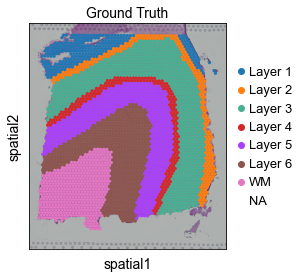

In [8]:
sc.pl.spatial(adata, img_key="hires", color='layer', title='Ground Truth', size=1.5, show=False)

In [9]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

## Running model

In [10]:
adata_sample, adata_stage = STAGE.STAGE(
    adata, 
    save_path='./T1_DLPFC_recovery', 
    data_type='10x',
    experiment='recovery',
    down_ratio=0.5,
    coord_sf=77, 
    train_epoch=2000,
    batch_size=512, 
    learning_rate=1e-3,
    w_recon=0.1, 
    w_w=0.1, 
    w_l1=0.1
)

Epochs: 100%|██████| 2000/2000 [16:28<00:00,  2.37it/s, latent_loss: 0.01085, recon_loss: 0.16271, total_loss: 0.02713]


In [11]:
adata_sample

View of AnnData object with n_obs × n_vars = 1820 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'layer'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'layer_colors', 'hvg', 'log1p'
    obsm: 'spatial', 'coord'

In [12]:
adata_stage

AnnData object with n_obs × n_vars = 3639 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'layer'
    obsm: 'coord'

## Genes spatial visualizaion

In [13]:
sc.set_figure_params(dpi=80, figsize=(2.8, 3))

In [14]:
adata.obsm['coord'][:,1] = adata.obsm['coord'][:,1]*(-1)

In [15]:
show_gene=["PCP4","FABP4"]

[<AxesSubplot:title={'center':'PCP4'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'FABP4'}, xlabel='coord1', ylabel='coord2'>]

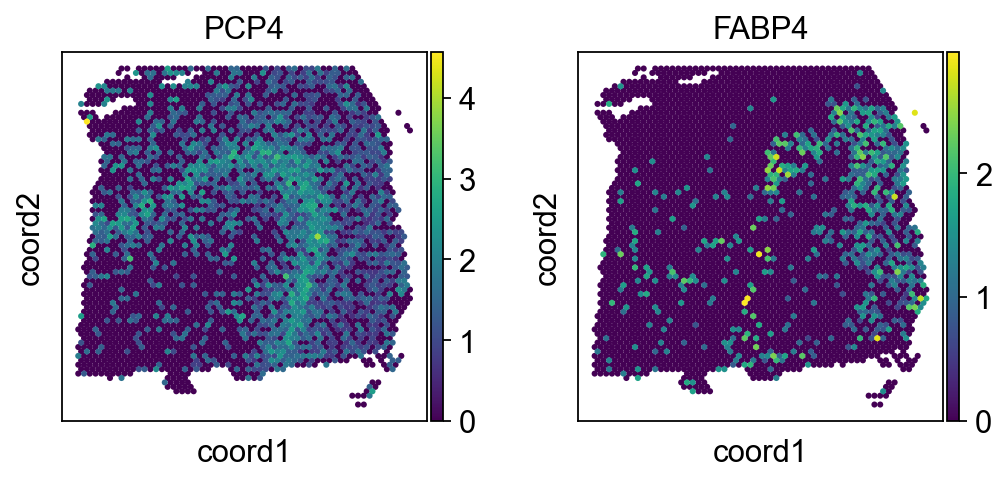

In [16]:
sc.pl.embedding(adata, basis="coord", color=show_gene, s=30, show=False)

[<AxesSubplot:title={'center':'PCP4'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'FABP4'}, xlabel='coord1', ylabel='coord2'>]

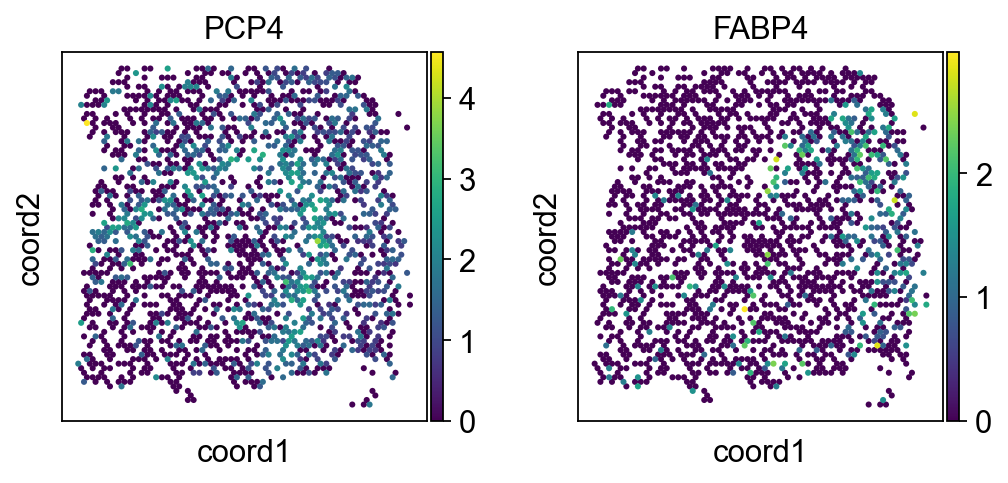

In [17]:
sc.pl.embedding(adata_sample, basis="coord", color=show_gene, s=30, show=False)

[<AxesSubplot:title={'center':'PCP4'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'FABP4'}, xlabel='coord1', ylabel='coord2'>]

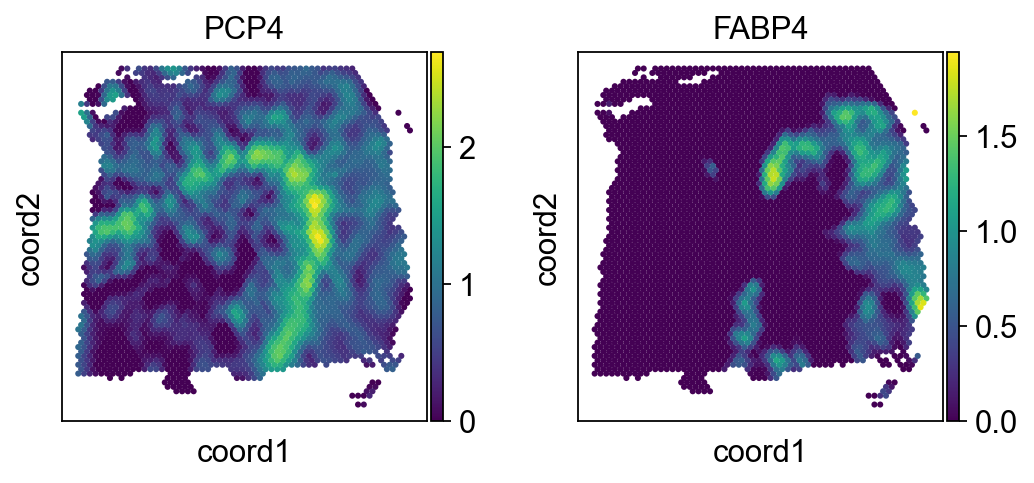

In [18]:
sc.pl.embedding(adata_stage, basis="coord", color=show_gene, s=30, show=False)

## Spatial trajectory inference (PAGA)

In [19]:
sc.pp.pca(adata, n_comps=30)
sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.umap(adata)

In [20]:
sc.pp.pca(adata_sample, n_comps=30)
sc.pp.neighbors(adata_sample, use_rep='X_pca')
sc.tl.umap(adata_sample)

In [21]:
sc.pp.pca(adata_stage, n_comps=30)
sc.pp.neighbors(adata_stage, use_rep='X_pca')
sc.tl.umap(adata_stage)

In [22]:
used_adata = adata[adata.obs['layer'].isna()==False,]
sc.tl.paga(used_adata, groups='layer')

In [23]:
used_adata_sample = adata_sample[adata_sample.obs['layer'].isna()==False,]
sc.tl.paga(used_adata_sample, groups='layer')

In [24]:
used_adata_stage = adata_stage[adata_stage.obs['layer'].isna()==False,]
sc.tl.paga(used_adata_stage, groups='layer')

In [25]:
sc.set_figure_params(dpi=80, figsize=(4, 3))

[<Axes:xlabel='UMAP1', ylabel='UMAP2'>, <Axes:>]

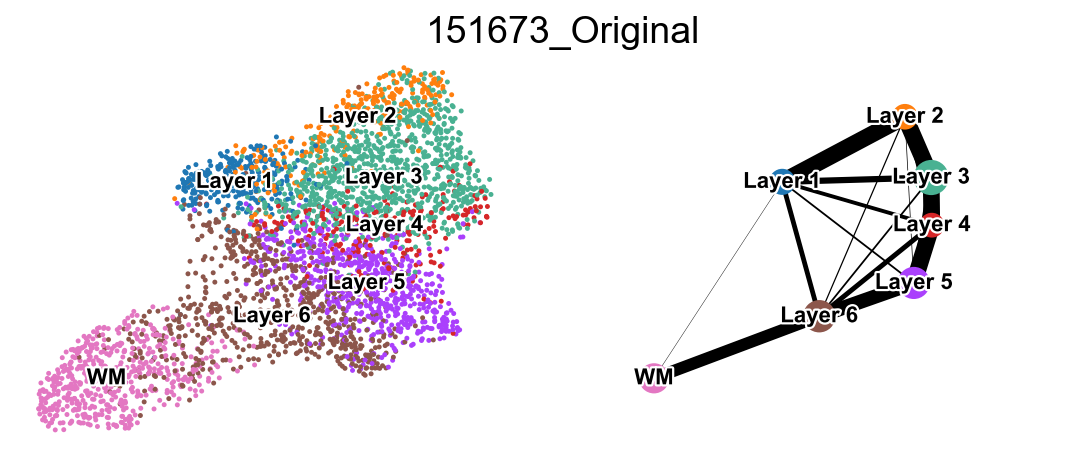

In [26]:
sc.pl.paga_compare(used_adata, legend_fontsize=10, frameon=False, size=20, 
                   title=section_id+'_Original', legend_fontoutline=2, show=False)

[<Axes:xlabel='UMAP1', ylabel='UMAP2'>, <Axes:>]

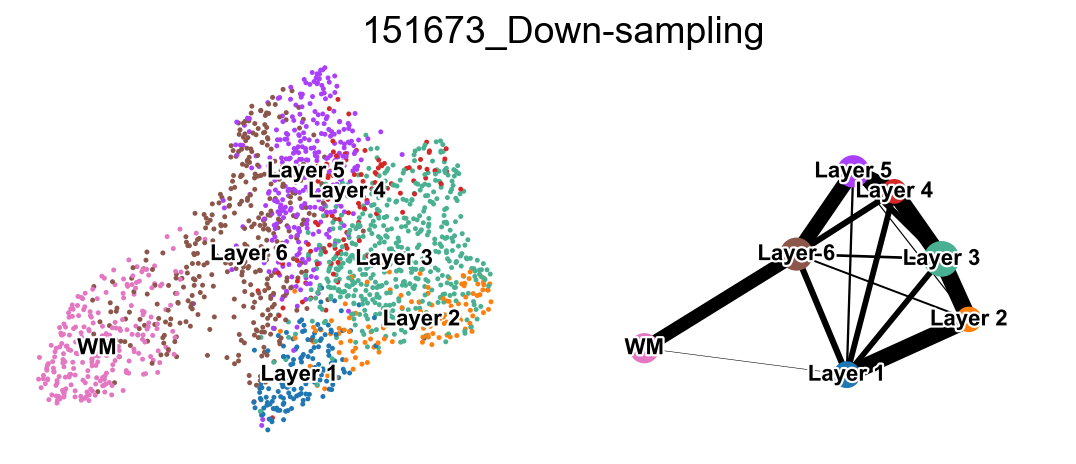

In [27]:
sc.pl.paga_compare(used_adata_sample, legend_fontsize=10, frameon=False, size=20, 
                   title=section_id+'_Down-sampling', legend_fontoutline=2, show=False)

[<Axes:xlabel='UMAP1', ylabel='UMAP2'>, <Axes:>]

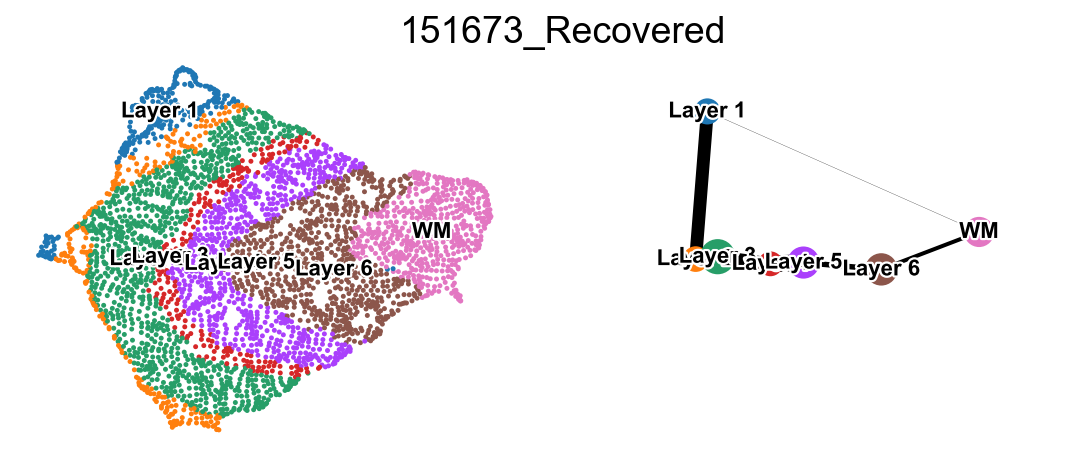

In [28]:
sc.pl.paga_compare(used_adata_stage, legend_fontsize=10, frameon=False, size=20, 
                   title=section_id+'_Recovered', legend_fontoutline=2, show=False)